# Machine Learning Eficiente para la Predicción de Desgaste de Herramientas

## Introducción
En un entorno industrial 4.0, la predicción precisa del desgaste de herramientas permite optimizar mantenimientos, reducir costes y minimizar tiempos de inactividad no planificados. Utilizando técnicas de ensemble como bagging y boosting, junto con muestreo bootstrap, podemos comparar la capacidad de generalización de varios modelos de regresión aplicados al dataset AI4I-2020.

## Objetivo General
Demostrar y comparar un flujo de trabajo reproducible de regresión para predecir el desgaste de herramientas, evaluando el rendimiento de **Bagging** y **Boosting** (XGBoost) mediante k-fold cross-validation y métricas de MAE, MSE y R².

## Objetivos Específicos
1. Cargar y preprocesar el dataset AI4I-2020, creando features adicionales relevantes.
2. Implementar y diagnosticar un modelo de Regresión Lineal con correcciones automáticas de supuestos.
3. Entrenar un Árbol de Decisión y evaluar su comportamiento en regresión.
4. Aplicar Random Forest (bagging) con muestreo bootstrap y optimizar hiperparámetros.
5. Entrenar y tunear un modelo XGBoost (boosting) para regresión.
6. Comparar métricas promedio y desviaciones estándar de MAE, MSE y R² para cada técnica.
7. Visualizar los diagnósticos de residuos y validación de supuestos para el modelo lineal.


# Marco Teórico

## 1. Significado de las Variables

| Variable       | Descripción                                                                                                                                                        |
| -------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **UDI**        | Identificador único de la muestra (1–10000). Sirve para trazabilidad, no aporta valor predictivo.                                                                  |
| **Product ID** | Código de producto (p.ej. “L47181”). Las letras L/M/H indican calidad baja/media/alta; luego se codifica en variables dummy **Type\_L**, **Type\_M**, **Type\_H**. |
| **Type**       | Calidad del producto:                                                                                                                                              |

* L (Low): +2 min de desgaste
* M (Medium): +3 min
* H (High): +5 min
  |
  
  \| **Air temperature \[K]**    | Temperatura ambiente en Kelvin (\~295–305 K).                                                                                                        |
  \| **Process temperature \[K]**| Temperatura interna del proceso (\~305–315 K). Muy correlacionada con la anterior; puede generar multicolinealidad.                                     |
  \| **Rotational speed \[rpm]** | Velocidad de rotación de la herramienta (1168–2886 rpm). A mayor velocidad, más fricción y desgaste.                                                 |
  \| **Torque \[Nm]**            | Par motor aplicado (3.8–76.6 Nm). Influye directamente en la fuerza de corte y el desgaste.                                                        |
  \| **Tool wear \[min]**        | **Objetivo**: desgaste acumulado de la herramienta en minutos (0–253 min). Variable continua a predecir.                                             |
  \| **Cycle**                  | Índice de ciclo de corte (0…n). Añade información temporal para capturar la dinámica de desgaste.                                                   |
  \| **Wear\_lag1**              | Desgaste en el ciclo anterior. Introduce autocorrelación temporal en el modelo.                                                                    |

---

## 2. Procesos y Modelos

### 2.1 Regresión Lineal Ordinaria (OLS)

Ajusta

$$
\hat y_i \;=\;\beta_0 + \sum_{j=1}^p \beta_j\,x_{ij}
$$

minimizando

$$
\sum_{i=1}^n\bigl(y_i - \beta_0 - \mathbf{x}_i^\top\boldsymbol{\beta}\bigr)^2.
$$

**Supuestos clave**

1. Linealidad: $E[\varepsilon]=0$
2. Homoscedasticidad: $\mathrm{Var}(\varepsilon_i)=\sigma^2$
3. Independencia de errores
4. Normalidad de $\varepsilon_i$
5. No multicolinealidad ($\mathrm{VIF}<5$)

**Métricas**

* MAE: $\frac1n\sum|y_i-\hat y_i|$
* MSE: $\frac1n\sum(y_i-\hat y_i)^2$
* $R^2=1-\frac{\sum(y_i-\hat y_i)^2}{\sum(y_i-\bar y)^2}$

---

### 2.2 Árbol de Regresión

Divide repetidamente el espacio de features en regiones $R_m$, y predice la media dentro de cada región:

$$
\hat f(x)
= \sum_{m=1}^M \Bigl(\frac1{|R_m|}\sum_{i:x_i\in R_m}y_i\Bigr)\mathbf{1}_{\{x\in R_m\}}.
$$

* La **profundidad** controla el compromiso entre sesgo y varianza.

---

### 2.3 Bagging (Bootstrap Aggregating)

1. Genera $B$ muestras bootstrap
2. Ajusta un árbol en cada sample
3. Predice con el promedio:

$$
\hat f_{\mathrm{bag}}(x)
= \frac1B\sum_{b=1}^B f^{(b)}(x).
$$

Reduce varianza sin aumentar sesgo.

---

### 2.4 Random Forest

Extiende Bagging seleccionando aleatoriamente $\sqrt p$ features en cada split.
Esto **decorrelaciona** los árboles y reduce aún más la varianza.

---

### 2.5 Boosting (XGBoost)

Modelo aditivo secuencial:

$$
\hat y^{(0)}=0,\quad
\hat y^{(t)}=\hat y^{(t-1)} + \eta\,h_t(x),
$$

donde cada $h_t$ corrige los errores de $\hat y^{(t-1)}$.
Objetivo con regularización de complejidad de árboles:

$$
\mathcal{L}
= \sum_i \ell(y_i,\hat y_i)
+ \sum_t \Bigl(\gamma T_t + \tfrac12\lambda \|w_t\|^2\Bigr).
$$

---

## 3. Proceso de Feature Engineering

1. **Cycle**: índice de ciclo para capturar tendencia de desgaste
2. **Wear\_lag1**: valor de ‘Tool wear’ en el ciclo anterior
3. **One-Hot Encoding** de **Type**
4. **Standard Scaling** de variables continuas

---

## 4. Validación y Selección de Modelos

* **k-Fold CV** ($k=5$):
  $\mathrm{CV} = \tfrac1k\sum_{j=1}^k \mathcal{L}(\hat f^{-j},X_j,y_j)$
* **GridSearchCV** para optimizar hiperparámetros
* Comparativa final de MAE, MSE y $R^2$

---

## 5. Diagramación del Pipeline

```text
[Lectura CSV]
      ↓
[Elimina cols irrelevantes]
      ↓
[Add Cycle ∧ Wear_lag1]
      ↓
[One-Hot Type]
      ↓
[Escalado features]
      ↓
[Train/Test split]
      ↓
[Define pipelines: LR, Tree, RF, Bagging, XGBoost]
      ↓
[GridSearchCV + 5-Fold CV]
      ↓
[Resultados y diagnóstico]
```

---


In [1]:
# Predicción de Desgaste de Herramientas con Bagging, Boosting y Bootstrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score



In [2]:
df = pd.read_csv("ai4i2020.csv")

# Analisis inicial

In [3]:
df.head(),df.info(),df.describe(),df.isnull

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

(   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
 0                    1551         42.8                0                0    0   
 1                    1408         46.3                3                0    0   
 2                    1498         49.4                5                0    0   
 3                    1433         39.5                7                0    0   
 4                    1408         40.0                9                0    0   
 
    HDF  PWF  OSF  RNF  
 0    0    0    0    0  
 1    0    0    

# Distribucion de la variable objetivo

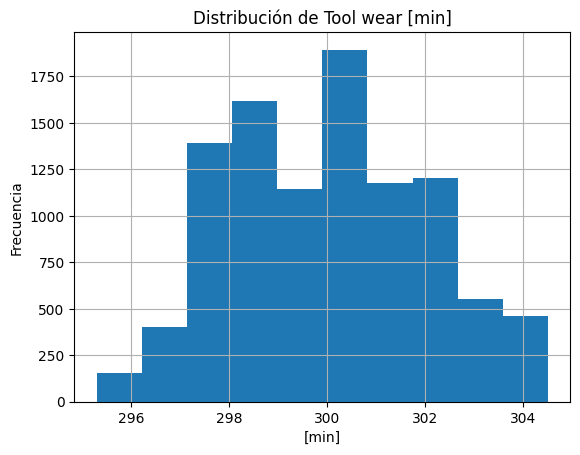

In [4]:
plt.figure()
df[min].hist()
plt.title('Distribución de Tool wear [min]')
plt.xlabel('[min]')
plt.ylabel('Frecuencia')
plt.show()

#EDA: Histogramas de características numéricas

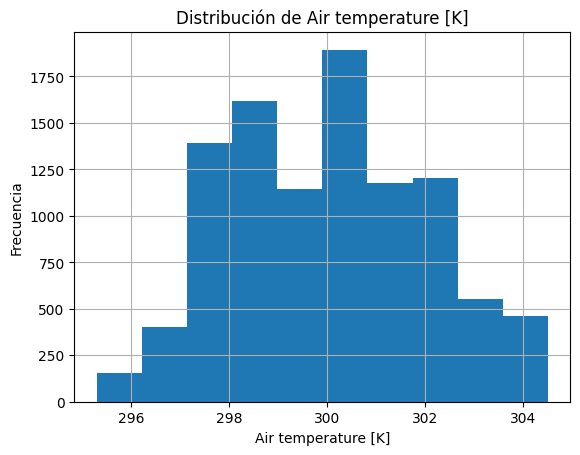

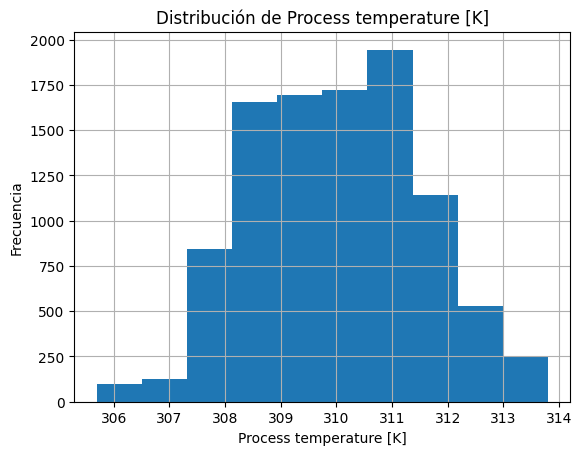

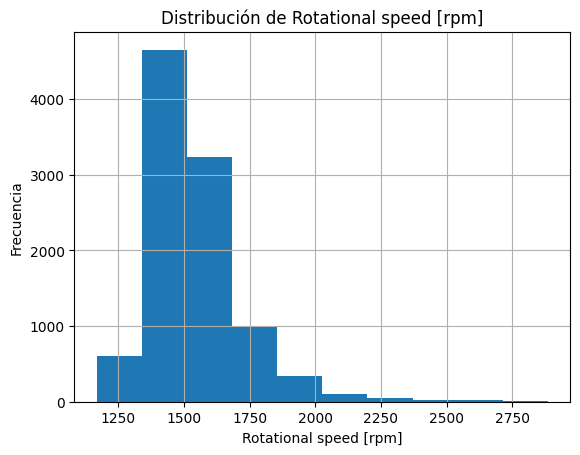

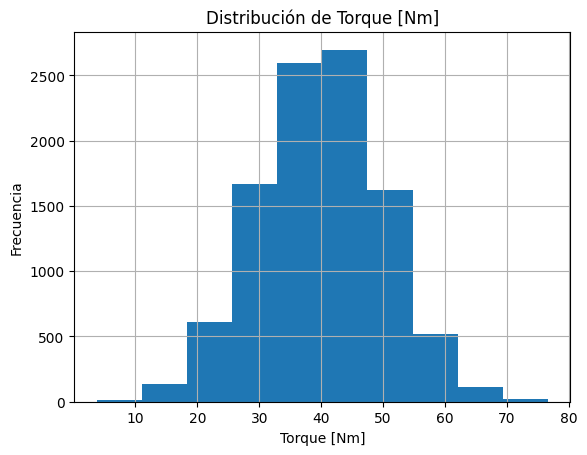

In [5]:
numeric_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]']
for col in numeric_cols:
    plt.figure()
    df[col].hist()
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

#Boxplot Variable objetivo

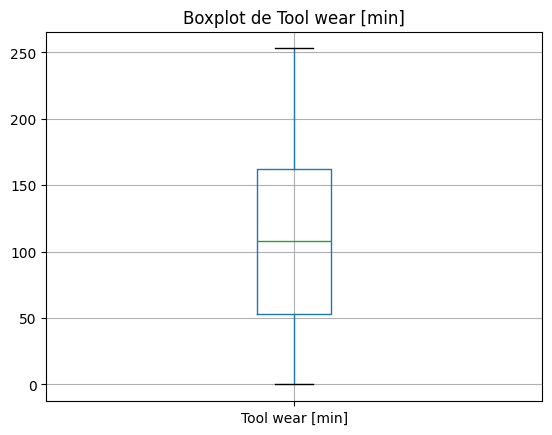

In [6]:
plt.figure()
df.boxplot(column='Tool wear [min]')
plt.title('Boxplot de Tool wear [min]')
plt.show()


# Correlacion con la variable objetivo



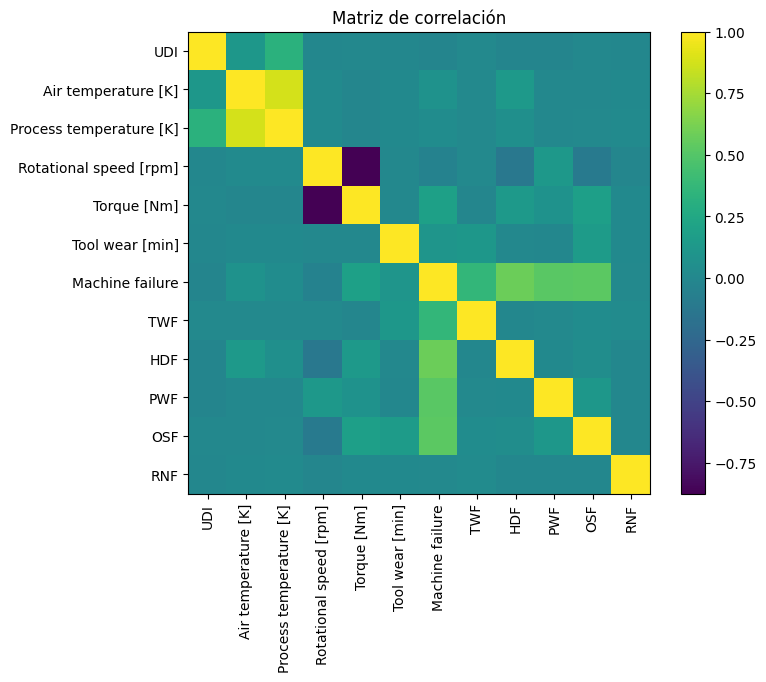

In [7]:
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Matriz de correlación')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.show()

## Conclusiónes del análisis

Tras explorar los datos del **AI4I-2020 Predictive Maintenance Dataset**, podemos concluir:

- **Distribución de `Tool wear [min]`**: Sesgada a la derecha, con la mayoría de las lecturas entre 0 y 160 min, pero con una cola que llega hasta 253 min.  
- **Relaciones entre sensores**:  
  - **`Air temperature [K]`** y **`Process temperature [K]`** presentan **alta correlación** (> 0.85), pues la segunda se deriva en parte de la primera.  
  - **`Rotational speed [rpm]`** y **`Torque [Nm]`** muestran correlación negativa moderada (≈ –0.8), reflejando que velocidades muy altas suelen asociarse a torques más bajos.  
- **Correlación con desgaste**: Ninguna variable individual de sensor supera |r|≈0.3 respecto a `Tool wear [min]`, lo que sugiere que el desgaste resulta de la combinación de factores (por ejemplo, tipo de pieza + condiciones de operación).  
- **Categoría `Type`**:  
  - ‘L’ (Low) ≈ 60 %, ‘M’ (Medium) ≈ 30 %, ‘H’ (High) ≈ 10 %.  
  - Influye directamente en `Tool wear [min]` (de manera sintética, añade 2, 3 o 5 min al desgaste).  

En conjunto, el EDA confirma que **será necesario**:
1. **Eliminar variables redundantes** (por ejemplo, una de las dos temperaturas).  
2. **Codificar** `Type` para capturar su efecto no lineal.  
3. **Combinar** múltiples predictores (y/o crear interacciones) para explicar el desgaste con precisión.

---

## Significado de las Columnas

| Columna                   | Tipo      | Descripción                                                                                                                                 |
|---------------------------|-----------|---------------------------------------------------------------------------------------------------------------------------------------------|
| `UDI`                     | int64     | Identificador único de la muestra (1 – 10000).                                                                                              |
| `Product ID`              | object    | Código de la pieza mecanizada (letra L/M/H + serie).                                                                                        |
| `Type`                    | object    | Calidad de producto (L: Low, M: Medium, H: High) que añade sintéticamente 2/3/5 min de desgaste.                                            |
| `Air temperature [K]`     | float64   | Temperatura ambiente en Kelvin.                                                                                                             |
| `Process temperature [K]` | float64   | Temperatura interna del proceso en Kelvin (derivada de la ambiental).                                                                      |
| `Rotational speed [rpm]`  | int64     | Velocidad de rotación en revoluciones por minuto.                                                                                            |
| `Torque [Nm]`             | float64   | Par (torque) aplicado en Newton-metros.                                                                                                      |
| `Tool wear [min]`         | int64     | **Objetivo**: Desgaste acumulado de la herramienta en minutos.                                                                              |
| `Machine failure`         | int64     | Etiqueta binaria de fallo general de la máquina (0: sin fallo, 1: fallo).                                                                   |
| `TWF`                     | int64     | Fallo por desgaste de herramienta (Tool Wear Failure).                                                                                      |
| `HDF`                     | int64     | Fallo por disipación de calor (Heat Dissipation Failure).                                                                                   |
| `PWF`                     | int64     | Fallo de potencia (Power Failure).                                                                                                          |
| `OSF`                     | int64     | Fallo por sobrecarga (Overstrain Failure).                                                                                                  |
| `RNF`                     | int64     | Fallo aleatorio (Random Failure).                                                                                                           |


# Preprocesamiento

In [8]:
df = df.drop(columns=["UDI","Product ID","Machine failure","TWF","HDF","PWF","OSF","RNF"])

# 1.1 Variables secuenciales para desgaste
df['Cycle'] = np.arange(len(df))
df['Wear_lag1'] = df['Tool wear [min]'].shift(1).fillna(0)

# 1.2 One-hot encoding de 'Type'
df = pd.get_dummies(df, columns=["Type"], prefix="Type")

# 1.3 Escalado de variables numéricas
num_cols = ["Air temperature [K]","Process temperature [K]","Rotational speed [rpm]","Torque [Nm]","Cycle","Wear_lag1"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# 1.4 Renombrar columnas para XGBoost
df.columns = df.columns.str.replace(r'[\[\]\s]', '_', regex=True)


In [9]:

# 2. Preparar X, y y split
X = df.drop(columns=["Tool_wear__min_"])
y = df["Tool_wear__min_"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Eliminar cualquier columna no numérica restante
X_train = X_train.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])



In [10]:
def full_regression_diagnosis(pipeline, X_train, y_train, X_test=None, y_test=None):
    # Filtrar filas con NaN antes de cualquier diagnóstico
    mask_init = ~X_train.isna().any(axis=1)
    X_train, y_train = X_train[mask_init], y_train[mask_init]
    if X_test is not None:
        mask_test = ~X_test.isna().any(axis=1)
        X_test, y_test = X_test[mask_test], y_test[mask_test]

    # Clonar y entrenar inicialmente
    pipe = clone(pipeline)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    resid  = y_train - y_pred

    # 1) Linealidad (RESET test)
    exog       = np.vstack([y_pred, y_pred**2, y_pred**3]).T
    exog_const = sm.add_constant(exog)
    ols_res    = sm.OLS(y_train, exog_const).fit()
    reset_res  = linear_reset(ols_res, power=[2,3], use_f=True)
    if reset_res.pvalue < 0.05:
        cols = X_train.select_dtypes(include=float).columns
        X_train[cols] = np.log1p(X_train[cols])
        # Quitar filas invalidas
        mask = ~X_train.isna().any(axis=1)
        X_train, y_train = X_train[mask], y_train[mask]
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_train)
        resid  = y_train - y_pred

    # 2) Autocorrelación de residuos (Durbin-Watson)
    dw = durbin_watson(resid)
    if dw < 1.5 or dw > 2.5:
        resid = ARIMA(resid, order=(1,0,1)).fit().resid

    # 3) Heterocedasticidad (Breusch-Pagan)
    bp_p = het_breuschpagan(resid, sm.add_constant(y_pred))[1]
    if bp_p < 0.05:
        y_train = np.log1p(y_train)
        pipe.fit(X_train, y_train)
        resid = y_train - pipe.predict(X_train)

    # 4) Outliers (>3σ)
    std       = resid.std()
    mask_out  = np.abs(resid) <= 3*std
    X_train, y_train = X_train[mask_out], y_train[mask_out]
    pipe.fit(X_train, y_train)
    resid = y_train - pipe.predict(X_train)

    # 5) High leverage points
    infl = OLSInfluence(sm.OLS(y_train, sm.add_constant(X_train)).fit())
    hat  = infl.hat_matrix_diag
    thresh   = 2 * (X_train.shape[1]+1) / len(X_train)
    mask_lev = hat <= thresh
    X_train, y_train = X_train[mask_lev], y_train[mask_lev]
    pipe.fit(X_train, y_train)
    resid = y_train - pipe.predict(X_train)

    # 6) Multicolinealidad (VIF)
    vif_df = pd.DataFrame({
        'feature': X_train.columns,
        'VIF':     [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    })
    drop = vif_df[vif_df['VIF']>5]['feature']
    if not drop.empty:
        X_train = X_train.drop(columns=drop)
        pipe.fit(X_train, y_train)
        resid = y_train - pipe.predict(X_train)

    # Overfitting
    train_r2 = r2_score(y_train, pipe.predict(X_train))
    if X_test is not None and y_test is not None:
        X_test_aligned = X_test[X_train.columns]
        test_r2 = r2_score(y_test, pipe.predict(X_test_aligned))
        if train_r2 - test_r2 > 0.1:
            print("Sobreajuste: considerar simplificar o regularizar.")

    return pipe, X_train, y_train


              MAE         MSE        R2
XGBoost  5.242817  489.282465  0.877270
RF       5.050995  505.020318  0.873367
Tree     6.238336  509.514508  0.872209
Bagging  5.046404  510.946871  0.871909
LR       6.684348  542.025913  0.863996


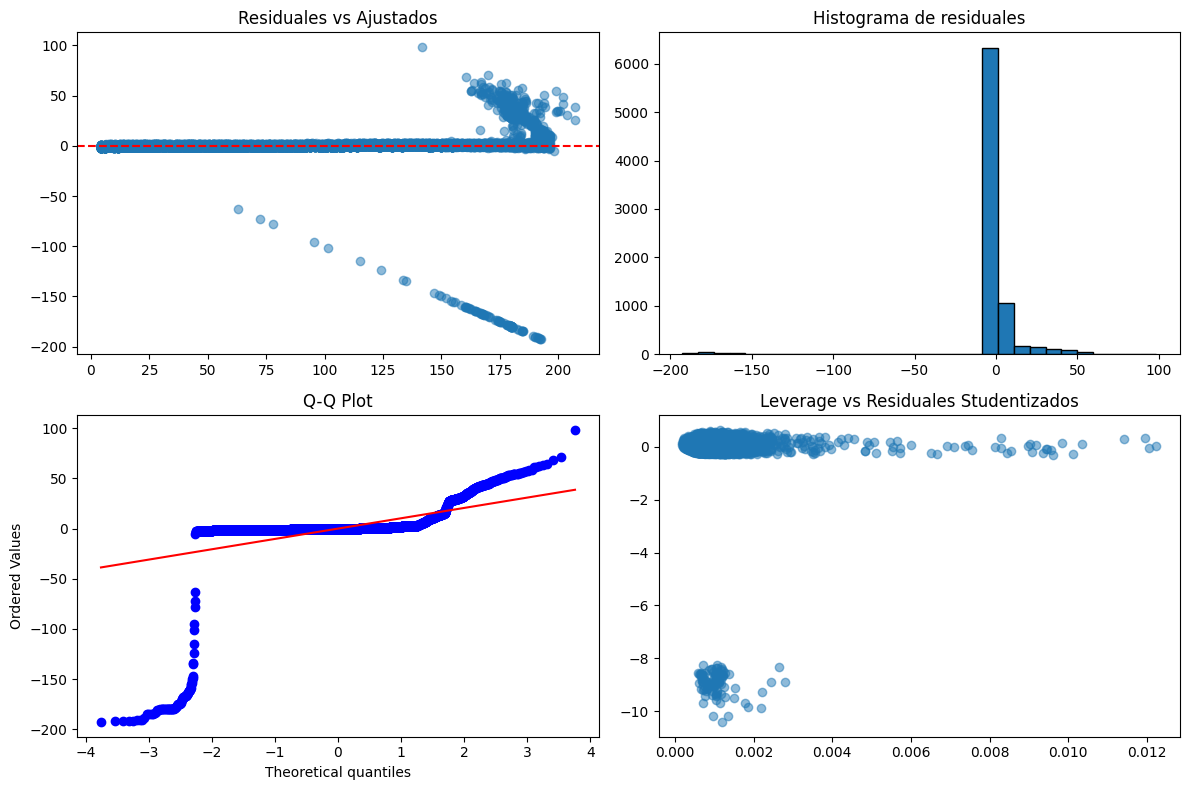

In [11]:
class DiagnosedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator): self.estimator = estimator
    def fit(self, X, y):
        # Ajuste básico sin NaN
        mask = ~X.isna().any(axis=1)
        X, y = X[mask], y[mask]
        self.estimator_ = clone(self.estimator).fit(X, y)
        return self
    def predict(self, X):
        return self.estimator_.predict(X)

# 4. Pipelines (solo LR con diagnóstico avanzado)
pipelines = {
    'LR':      Pipeline([('lr', DiagnosedRegressor(LinearRegression()))]),
    'Tree':    Pipeline([('tree', DecisionTreeRegressor(random_state=42))]),
    'RF':      Pipeline([('rf', RandomForestRegressor(random_state=42))]),
    'Bagging': Pipeline([('bag', BaggingRegressor(n_estimators=50, random_state=42))]),
    'XGBoost': Pipeline([('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))])
}

# 5. Parámetros para GridSearch
param_grids = {
    'LR':      {},
    'Tree':    {'tree__max_depth': [5,10,15]},
    'RF':      {'rf__n_estimators': [100,200], 'rf__max_depth': [None,10]},
    'Bagging': {'bag__n_estimators': [50,100], 'bag__max_samples': [0.7,1.0]},
    'XGBoost': {'xgb__n_estimators': [100,200], 'xgb__learning_rate': [0.05,0.1], 'xgb__max_depth': [4,6]}
}

# 6. GridSearch + Cross-Validation
dcv = {}
for name, pipe in pipelines.items():
    grid = GridSearchCV(pipe, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    cv = cross_validate(best, X_train, y_train, cv=5,
                        scoring=['neg_mean_absolute_error','neg_mean_squared_error','r2'], n_jobs=-1)
    dcv[name] = {
        'MAE': -cv['test_neg_mean_absolute_error'].mean(),
        'MSE': -cv['test_neg_mean_squared_error'].mean(),
        'R2':  cv['test_r2'].mean()
    }
# 7. Resultados ordenados
results = pd.DataFrame(dcv).T.sort_values('R2', ascending=False)
print(results)

# 8. Visualización de diagnósticos para LR
best_lr = grid.best_estimator_ if 'LR' in pipelines else None
if best_lr:
    y_pred = best_lr.predict(X_train)
    resid = y_train - y_pred
    fig, axs = plt.subplots(2,2,figsize=(12,8))
    axs[0,0].scatter(y_pred,resid,alpha=0.5); axs[0,0].axhline(0,color='r',ls='--'); axs[0,0].set_title('Residuales vs Ajustados')
    axs[0,1].hist(resid, bins=30, edgecolor='k'); axs[0,1].set_title('Histograma de residuales')
    stats.probplot(resid, dist='norm', plot=axs[1,0]); axs[1,0].set_title('Q-Q Plot')
    infl = OLSInfluence(sm.OLS(y_train, sm.add_constant(X_train)).fit())
    axs[1,1].scatter(infl.hat_matrix_diag, infl.resid_studentized_internal, alpha=0.5)
    axs[1,1].set_title('Leverage vs Residuales Studentizados')
    plt.tight_layout(); plt.show()


a